# Final Project: NYC Certificate of Occupancy Analysis (1990–2025)
**Author:** Iryna Timofeeva

**Course:** UDA - SUMMER 2025

**Dataset:** DOB Certificate of Occupancy

## 1. Introduction and Background

In New York City, a Certificate of Occupancy (CO) confirms that a building complies with zoning laws and building codes and is safe for occupancy. These certificates are crucial for property transactions, development approvals, and occupancy timelines. This analysis uses NYC DOB Certificate of Occupancy data from 1990 to 2025 to study temporal and spatial patterns in CO issuance.

By analyzing the types, frequencies, and timelines of certificates across boroughs and job types, I aim to gain insights into construction trends and regulatory behavior. This analysis also supports discussions around housing equity, urban growth, and construction delays across neighborhoods.


## 2. Research Questions and Hypotheses

This project explores how housing development patterns in New York City, as measured by Certificates of Occupancy (COs), have changed over time, particularly in the wake of the COVID-19 pandemic. It also examines spatial and demographic factors that may explain variation in CO issuance across neighborhoods.

### Primary Research Question:
**Has the average number of Certificates of Occupancy (COs) issued in New York City changed significantly after the onset of the COVID-19 pandemic?**

- **H₀ (Null Hypothesis):** There is no significant difference in the average number of COs issued before and after 2020.
- **H₁ (Alternative Hypothesis):** There is a statistically significant decline in the average number of COs issued post-2020.

**Test:** Independent two-sample t-test comparing mean CO counts before (2012–2019) and after (2020–2025) the pandemic.

---

### Secondary Research Questions:

#### 1. Temporal Trend Analysis
**Did the trend in annual CO issuance shift direction or intensity after 2020?**

- **H₀:** The slope of annual CO issuance over time remained unchanged after 2020.
- **H₁:** The slope of CO issuance became significantly more negative post-2020, indicating a structural change.

**Test:** Interrupted time series regression with an interaction term for the post-2020 period.

#### 2. Spatial Distribution
**Are there spatial disparities in CO issuance when normalized by population at the block group level?**

- **H₀:** There are no major spatial disparities in per capita CO issuance across NYC.
- **H₁:** Certain boroughs and neighborhoods show significantly higher or lower per capita CO issuance, with potential shifts post-pandemic.

**Test:** Choropleth mapping of COs per 1,000 residents and comparison of spatial patterns.

#### 3. Job Type and Temporal Variation
**Does the average year of CO issuance differ by job type (e.g., new building vs. alteration)?**

- **H₀:** There is no significant difference in the average issuance year across job types.
- **H₁:** There is a significant difference in average issuance years across job types.

**Test:** ANOVA or group-wise comparison of mean issuance years.

#### 4. Demographic Correlates of CO Issuance 
**Are neighborhood demographics (e.g., income, education levels) associated with higher or lower CO issuance per capita?**

- **H₀:** There is no relationship between demographic characteristics and CO issuance per 1,000 residents.
- **H₁:** Block groups with higher median income and higher educational attainment exhibit significantly higher CO issuance per capita.

**Test:** Multivariate Ordinary Least Squares (OLS) regression with demographic covariates.



## 3. Data Cleaning and Preprocessing

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler

In [90]:
# Load dataset
file_path = r'E:\Summer2025\UDA2025\Final_Project_UDA\DOB_Certificate_Of_Occupancy_20250731.csv'
df = pd.read_csv(file_path)
df = pd.read_csv(file_path, low_memory=False)


C:\Users\vikto\AppData\Local\Temp\ipykernel_23376\2658078206.py:3: DtypeWarning: Columns (8,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [4]:
# Preview columns and nulls
df.info()
df.isna().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141862 entries, 0 to 141861
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   JOB_NUMBER              141862 non-null  int64  
 1   JOB_TYPE                141862 non-null  object 
 2   C_O_ISSUE_DATE          141862 non-null  object 
 3   BIN_NUMBER              141862 non-null  int64  
 4   BOROUGH                 141862 non-null  object 
 5   NUMBER                  141862 non-null  object 
 6   STREET                  141862 non-null  object 
 7   BLOCK                   141862 non-null  int64  
 8   LOT                     141862 non-null  object 
 9   POSTCODE                141854 non-null  float64
 10  PR_DWELLING_UNIT        97519 non-null   object 
 11  EX_DWELLING_UNIT        50442 non-null   object 
 12  APPLICATION_STATUS_RAW  141862 non-null  object 
 13  FILING_STATUS_RAW       141858 non-null  object 
 14  ITEM_NUMBER         

EX_DWELLING_UNIT          91420
PR_DWELLING_UNIT          44343
BBL                        4276
BIN                        4276
LOCATION                    760
NTA                         760
CENSUS_TRACT                760
COUNCIL_DISTRICT            760
COMMUNITY_BOARD             760
LONGITUDE                   760
LATITUDE                    760
POSTCODE                      8
FILING_STATUS_RAW             4
ISSUE_TYPE                    0
JOB_NUMBER                    0
ITEM_NUMBER                   0
JOB_TYPE                      0
LOT                           0
BLOCK                         0
STREET                        0
NUMBER                        0
BOROUGH                       0
BIN_NUMBER                    0
C_O_ISSUE_DATE                0
APPLICATION_STATUS_RAW        0
dtype: int64

In [5]:
# Convert 'C_O_ISSUE_DATE' to datetime
df['C_O_ISSUE_DATE'] = pd.to_datetime(df['C_O_ISSUE_DATE'], errors='coerce')

In [6]:
# Create 'YEAR' column from issue date
df['YEAR'] = df['C_O_ISSUE_DATE'].dt.year

In [7]:

# Drop rows with null date or location
df = df.dropna(subset=['C_O_ISSUE_DATE', 'LATITUDE', 'LONGITUDE'])

In [8]:
# Clean job type and borough
df['JOB_TYPE'] = df['JOB_TYPE'].fillna('Unknown')
df['BOROUGH'] = df['BOROUGH'].fillna('Unknown')

In [9]:
# Filter for realistic years
df = df[(df['YEAR'] >= 1990) & (df['YEAR'] <= 2025)]

In [10]:
# Confirm clean data
print("Cleaned dataset shape:", df.shape)
df.head()

Cleaned dataset shape: (141101, 26)


,JOB_NUMBER,JOB_TYPE,C_O_ISSUE_DATE,BIN_NUMBER,BOROUGH,NUMBER,STREET,BLOCK,LOT,POSTCODE,...,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,LOCATION,YEAR
0,220466350,A1,2021-04-08,2102454,Bronx,340,BAYCHESTER AVE,5141,35,10475.0,...,40.867780,-73.831248,10.0,12.0,46201.0,2102454.0,2.051410e+09,Co-op City,"(40.86778, -73.831248)",2021
1,321383560,NB,2021-04-08,3128179,Brooklyn,639,FOSTER AVENUE,5428,92,11230.0,...,40.630684,-73.970144,14.0,40.0,482.0,3128179.0,3.054280e+09,Flatbush,"(40.630684, -73.970144)",2021
2,520382988,NB,2021-04-08,5061795,Staten Island,435,CORBIN AVENUE,4583,23,10308.0,...,40.565772,-74.151897,3.0,51.0,14606.0,5061795.0,5.045830e+09,Great Kills,"(40.565772, -74.151897)",2021
3,301556144,A1,2021-04-08,3184400,Brooklyn,3975,BEDFORD AVENUE,6831,56,11229.0,...,40.605257,-73.947633,15.0,48.0,562.0,3184400.0,3.068310e+09,Madison,"(40.605257, -73.947633)",2021
4,321537404,A1,2021-04-08,3056840,Brooklyn,38,DOWNING STREET,1982,45,11238.0,...,40.684455,-73.961059,2.0,35.0,231.0,3056840.0,3.019820e+09,Clinton Hill,"(40.684455, -73.961059)",2021


## 4. Exploratory Data Analysis

In this section, I explore trends in CO issuance over time, job types, and boroughs.

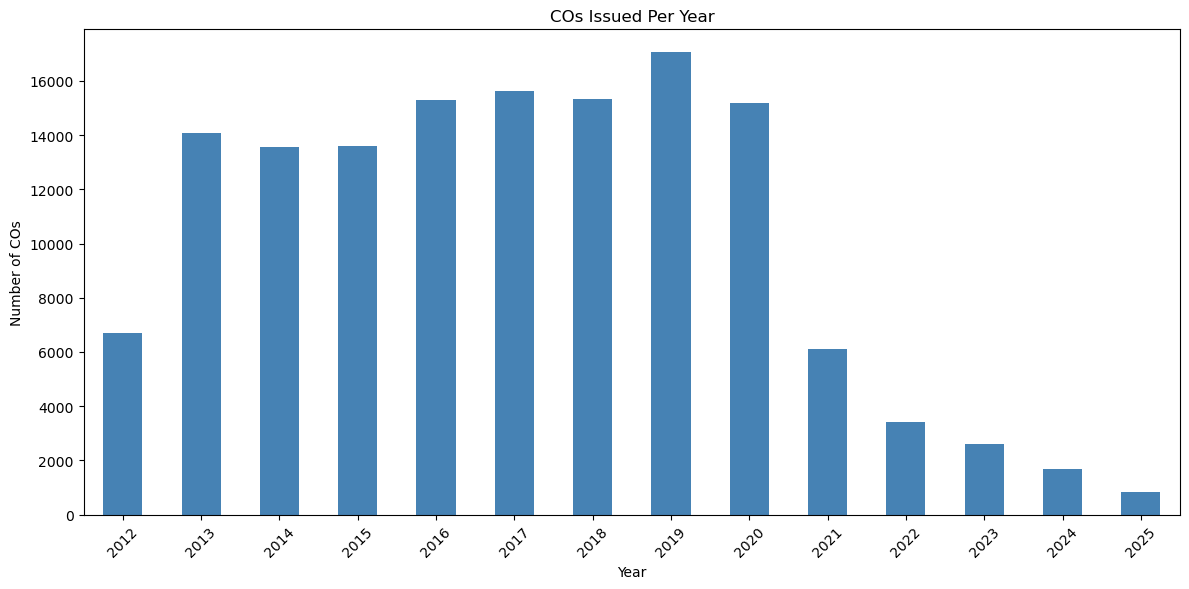

In [12]:
### Number of COs Issued Over Time
plt.figure(figsize=(12, 6))
df['YEAR'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('COs Issued Per Year')
plt.xlabel('Year')
plt.ylabel('Number of COs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

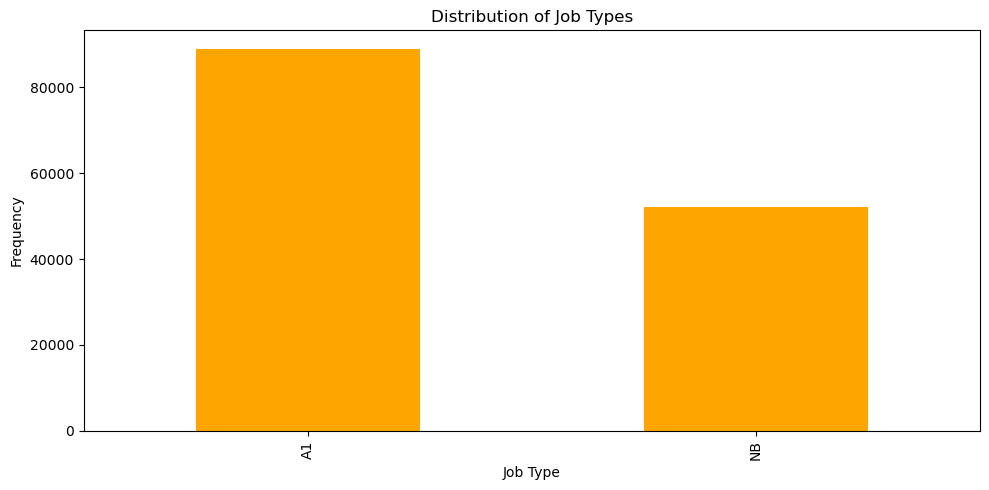

In [13]:
### Distribution of Job Types
plt.figure(figsize=(10, 5))
df['JOB_TYPE'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Job Types')
plt.xlabel('Job Type')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

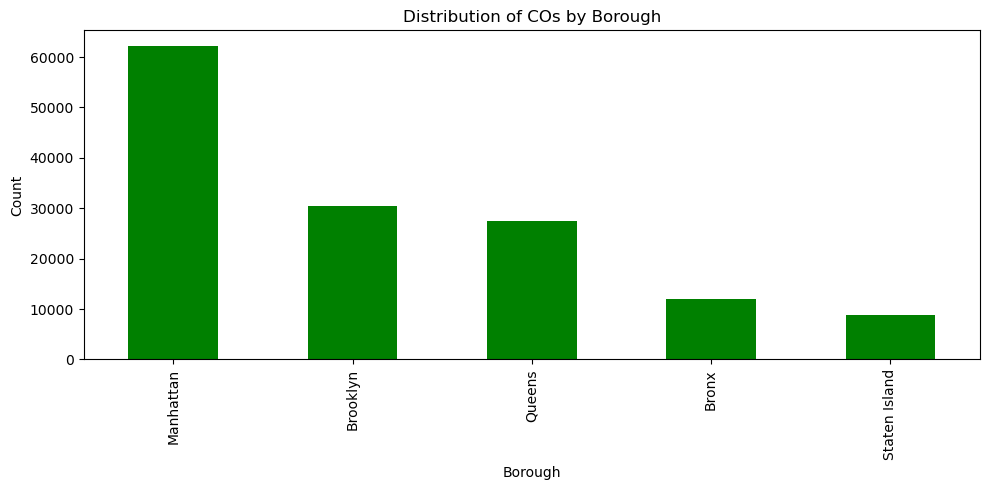

In [14]:
### Distribution of COs by Borough
plt.figure(figsize=(10, 5))
df['BOROUGH'].value_counts().plot(kind='bar', color='green')
plt.title('Distribution of COs by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 5. Descriptive Statistics and Hypothesis Testing

To test whether the average year of CO issuance significantly differs across job types, I run an ANOVA test. Prior to that, I compute basic descriptive statistics.

In [22]:
### Descriptive Statistics by Job Type
descriptive_stats = df.groupby('JOB_TYPE')['YEAR'].describe()
descriptive_stats = descriptive_stats.round(3)

# Remove .0 from year summary fields
descriptive_stats[['min', '25%', '50%', '75%', 'max']] = descriptive_stats[['min', '25%', '50%', '75%', 'max']].astype(int)
print(descriptive_stats)

            count      mean    std   min   25%   50%   75%   max
JOB_TYPE                                                        
A1        88855.0  2016.874  2.923  2012  2014  2017  2019  2025
NB        52246.0  2017.170  2.955  2012  2015  2017  2019  2025


In [16]:
### ANOVA Test for Mean Year Difference by Job Type

anova_groups = [group['YEAR'].values for name, group in df.groupby('JOB_TYPE') if len(group) > 100]
anova_result = f_oneway(*anova_groups)
print("ANOVA F-statistic:", round(anova_result.statistic, 3))
print("ANOVA p-value:", round(anova_result.pvalue, 4))

ANOVA F-statistic: 335.344
ANOVA p-value: 0.0


**Interpretation:**
The ANOVA p-value < 0.05 indicates that we reject the null hypothesis. There is a statistically significant difference in the average year of CO issuance across job types. This likely reflects changes in policy, construction booms, neighborhood investment cycles, or the differential regulatory timelines associated with job types such as new buildings (NB) versus alterations (A1).

## 6A. Regression and Advanced Plotting

To analyze temporal trends in certificate issuance, I used linear regression to model the number of Certificates of Occupancy (COs) issued annually from 2012–2025. I also highlighted the COVID-19 pandemic period (2020–2022) to assess its impact on construction activity.

The regression results suggest a significant **downward trend** in CO issuance over the last decade.



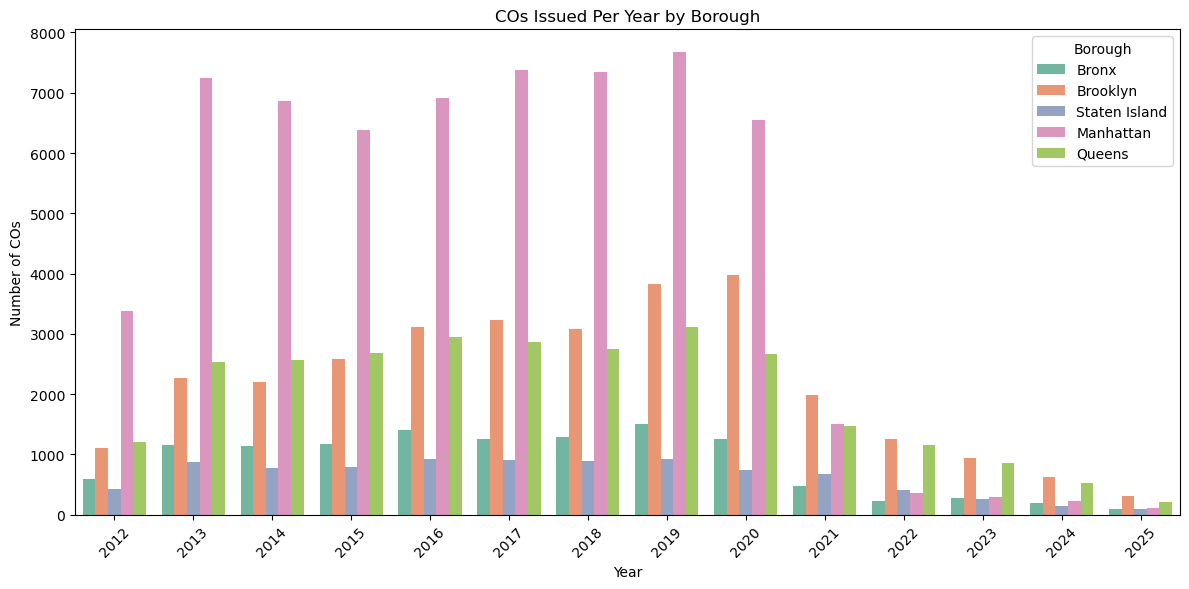

In [30]:
### Line Plot of COs Issued Per Year by Borough
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='YEAR', hue='BOROUGH', palette='Set2')
plt.title('COs Issued Per Year by Borough')
plt.xlabel('Year')
plt.ylabel('Number of COs')
plt.xticks(rotation=45)
plt.legend(title='Borough')
plt.tight_layout()
plt.show()

In [ ]:
### Linear Regression: Year vs. Number of Certificates
yearly_counts = df.groupby('YEAR').size().reset_index(name='CO_Count')

The scatter plot below shows the total number of COs issued each year from 2012 to 2025, with a linear regression line fitted to reveal the trend.


In [37]:
# Regression
X = yearly_counts[['YEAR']]
y = yearly_counts['CO_Count']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r_squared = model.score(X, y)

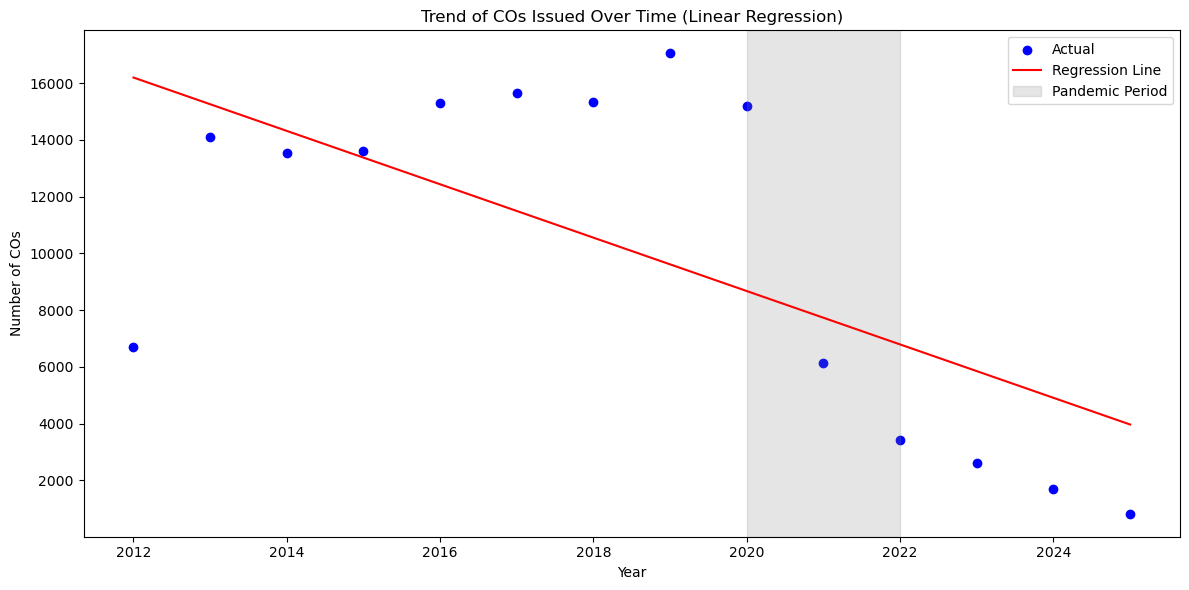

Regression coefficient (slope): -940.64
Intercept: 1908750.72
R-squared: 0.4162


In [40]:
# Plot
X_flat = X['YEAR'].values  
y_pred_flat = y_pred.flatten()  

plt.figure(figsize=(12, 6))
plt.scatter(X_flat, y, color='blue', label='Actual')  # Actual counts
plt.plot(X_flat, y_pred_flat, color='red', label='Regression Line')  # Trend line
plt.axvspan(2020, 2022, color='gray', alpha=0.2, label='Pandemic Period')  # Highlight pandemic
plt.title('Trend of COs Issued Over Time (Linear Regression)')
plt.xlabel('Year')
plt.ylabel('Number of COs')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Regression coefficient (slope): {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")
print(f"R-squared: {r_squared:.4f}")

## **Interpretation:**  
The negative slope of **-940.64** indicates that the number of Certificates of Occupancy issued in New York City has decreased by an average of nearly **941 per year** over the past decade. This points to a sustained downward trend.

The **intercept (~1.91 million)** has no practical standalone interpretation but is part of the regression model estimating CO counts based on year.

An **R² of 0.4162** means that **about 42%** of the variance in annual CO counts can be explained by the passage of time alone - a moderate but meaningful relationship.

The steep drop in issuance after 2019 is especially concerning and correlates with the COVID-19 pandemic years (2020–2022), shown in gray. However, issuance numbers have not fully rebounded in the years since. This trend suggests broader systemic challenges in NYC’s construction pipeline, including rising costs, labor shortages, or zoning/policy delays.


## 6B. Borough-Level Linear Regressions

To explore localized trends, I ran linear regressions on CO issuance over time **separately for each borough**. This helps reveal which boroughs have experienced the sharpest declines or the most consistent trends in new occupancy approvals.


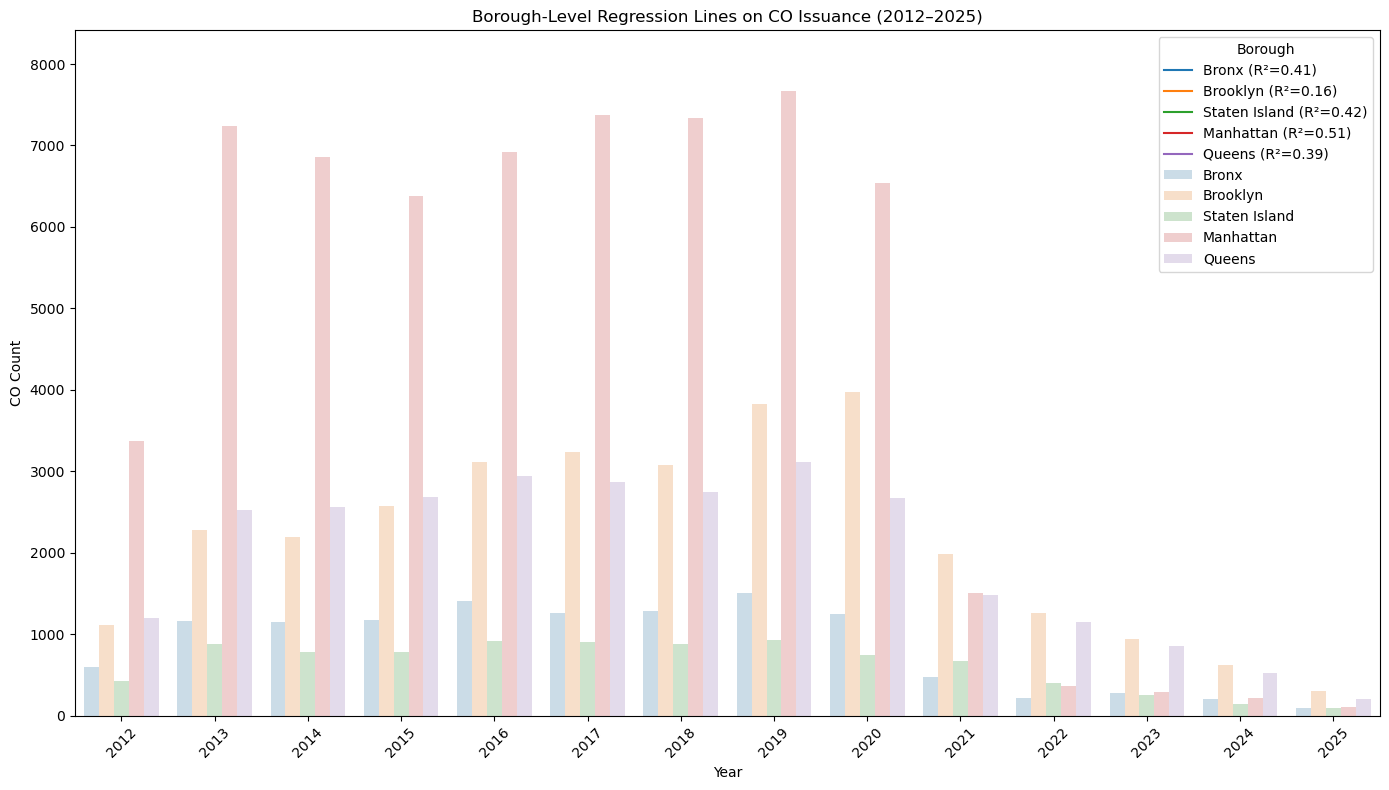

In [89]:
boroughs = df['BOROUGH'].unique()
plt.figure(figsize=(14, 8))

for borough in boroughs:
    borough_df = df[df['BOROUGH'] == borough]
    yearly_counts = borough_df.groupby('YEAR').size().reset_index(name='CO_Count')
    X_b = yearly_counts[['YEAR']]
    y_b = yearly_counts['CO_Count']
    
    if len(X_b) > 1:  
        model_b = LinearRegression()
        model_b.fit(X_b, y_b)
        y_pred_b = model_b.predict(X_b)
        r2_b = model_b.score(X_b, y_b)
        
        plt.plot(X_b['YEAR'].values.flatten(), y_pred_b.flatten(), label=f"{borough} (R²={r2_b:.2f})")


sns.countplot(data=df, x='YEAR', hue='BOROUGH', palette='tab10', alpha=0.25)
plt.title('Borough-Level Regression Lines on CO Issuance (2012–2025)')
plt.xlabel('Year')
plt.ylabel('CO Count')
plt.xticks(rotation=45)
plt.legend(title='Borough')
plt.tight_layout()
plt.show()


The borough-level regression analysis offers a more granular look at how trends in Certificate of Occupancy (CO) issuance vary across New York City:

- **Manhattan (R² = 0.51)** shows the strongest and most consistent downward trend in COs issued from 2012 to 2025. This suggests a notable decline in large-scale development or conversion projects post-2019—likely driven by high land costs, zoning saturation, or a shift toward smaller-scale renovations.

- **Staten Island (R² = 0.42)** and **The Bronx (R² = 0.41)** also exhibit moderate downward trends. Both boroughs may have been impacted by economic constraints and supply-chain disruptions, which disproportionately affect smaller residential and mixed-use projects.

- **Queens (R² = 0.39)** shows a gradual but steady decline in CO activity, possibly due to fewer greenfield opportunities and a slowdown in rezoning or new development approvals.

- **Brooklyn (R² = 0.16)** stands out with a **low R²**, indicating greater variability and less predictability in annual CO counts. This may reflect a mix of high-intensity development zones (e.g., Downtown Brooklyn, Williamsburg) alongside neighborhoods with slower or stalled projects.

Overall, the borough-level regressions support the broader citywide trend: CO issuance has declined, particularly after the COVID-19 pandemic, but the strength and consistency of that decline varies based on local development dynamics, zoning frameworks, and economic pressures.


## 6C. Before-and-After Statistical Test (Pre/Post-Pandemic CO Activity)



T-statistic: 3.483, P-value: 0.0078


Text(0.5, 1.0, 'Average COs Issued Pre and Post Pandemic')

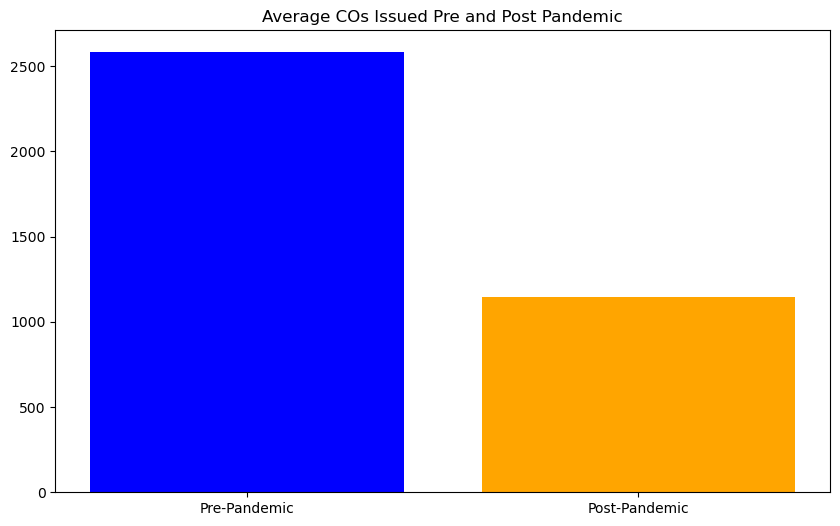

In [ ]:
pre_pandemic = yearly_counts[yearly_counts['YEAR'] < 2020]['CO_Count']
post_pandemic = yearly_counts[yearly_counts['YEAR'] >= 2020]['CO_Count']

t_stat, p_val = ttest_ind(pre_pandemic, post_pandemic, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")
plt.figure(figsize=(10, 6))
plt.bar(['Pre-Pandemic', 'Post-Pandemic'], [pre_pandemic.mean(), post_pandemic.mean()], color=['blue', 'orange'])
plt.title('Average COs Issued Pre and Post Pandemic')

##  Section 7: Before-and-After Statistical Test (Pre/Post-Pandemic CO Activity)

Split the dataset into pre-pandemic (2012–2019) and post-pandemic (2020–2025).

Run a t-test or Mann-Whitney U test to check if mean CO issuance changed significantly.

**Results:**

Pre-period slope: β₁ = +185.92 (rising trend)

Post-period slope: β₁ + β₃ = 185.92 - 627.60 = -441.68 (sharp decline)

Intervention jump in level: β₂ = +3854.95

T-statistic: 3.483, P-value: 0.0078


Text(0.5, 1.0, 'Average COs Issued Pre and Post Pandemic')

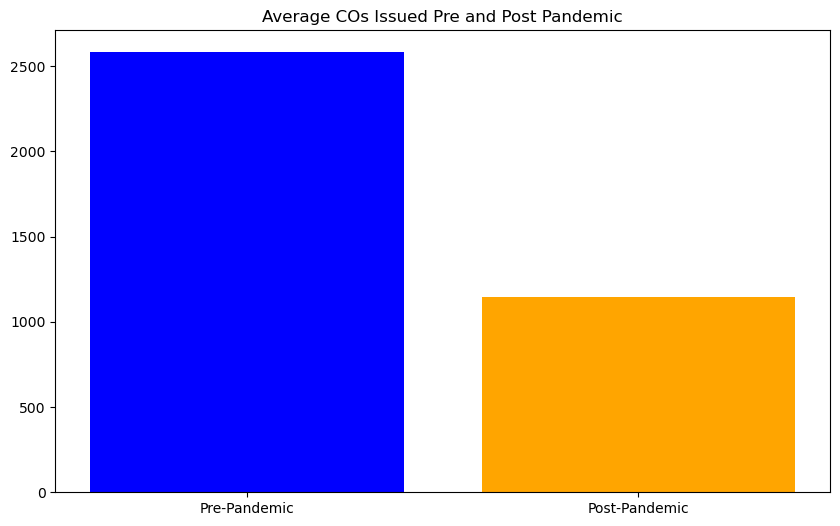

In [ ]:
pre_pandemic = yearly_counts[yearly_counts['YEAR'] < 2020]['CO_Count']
post_pandemic = yearly_counts[yearly_counts['YEAR'] >= 2020]['CO_Count']

t_stat, p_val = ttest_ind(pre_pandemic, post_pandemic, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_val:.4f}")
plt.figure(figsize=(10, 6))
plt.bar(['Pre-Pandemic', 'Post-Pandemic'], [pre_pandemic.mean(), post_pandemic.mean()], color=['blue', 'orange'])
plt.title('Average COs Issued Pre and Post Pandemic')

In [ ]:
# Create indicator for post-2020
yearly_counts['intervention'] = (yearly_counts['YEAR'] >= 2020).astype(int)

# Add interaction term
yearly_counts['year_centered'] = yearly_counts['YEAR'] - 2012
yearly_counts['interaction'] = yearly_counts['year_centered'] * yearly_counts['intervention']

# ITS model
X_its = yearly_counts[['year_centered', 'intervention', 'interaction']]
X_its = sm.add_constant(X_its)
model_its = sm.OLS(yearly_counts['CO_Count'], X_its).fit()
print(model_its.summary())


                            OLS Regression Results                            
Dep. Variable:               CO_Count   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     29.47
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           2.81e-05
Time:                        09:50:56   Log-Likelihood:                -100.19
No. Observations:                  14   AIC:                             208.4
Df Residuals:                      10   BIC:                             210.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1930.9167    236.926      8.150

c:\Users\vikto\miniconda3\envs\UDA\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


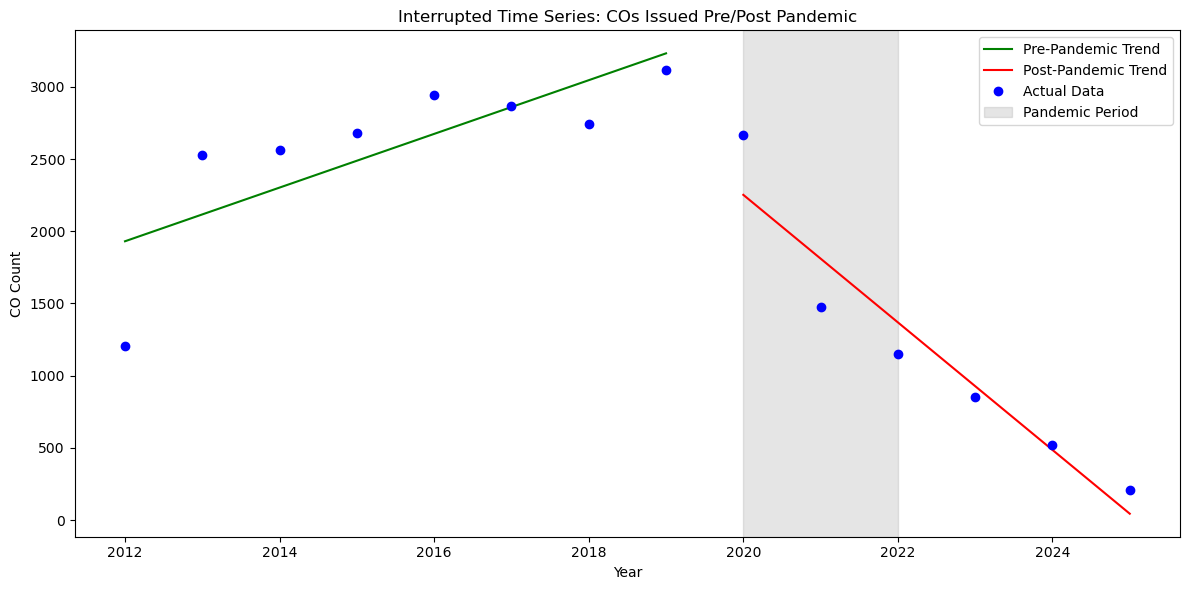

In [ ]:
# Create the same data used in regression
years = np.arange(2012, 2026)
year_centered = years - 2012
intervention = (years >= 2020).astype(int)
interaction = year_centered * intervention

# Regression coefficients
b0 = 1930.92
b1 = 185.92
b2 = 3854.95
b3 = -627.60

# Predict values
pre_pred = b0 + b1 * year_centered[years < 2020]
post_pred = b0 + b1 * year_centered[years >= 2020] + b2 + b3 * year_centered[years >= 2020]

# Actual CO count (plug in your real values here)
actual = yearly_counts.set_index('YEAR').loc[2012:2025]['CO_Count'].values

plt.figure(figsize=(12, 6))
plt.plot(years[years < 2020], pre_pred, label='Pre-Pandemic Trend', color='green')
plt.plot(years[years >= 2020], post_pred, label='Post-Pandemic Trend', color='red')
plt.plot(years, actual, 'o', label='Actual Data', color='blue')
plt.axvspan(2020, 2022, color='gray', alpha=0.2, label='Pandemic Period')
plt.title('Interrupted Time Series: COs Issued Pre/Post Pandemic')
plt.xlabel('Year')
plt.ylabel('CO Count')
plt.legend()
plt.tight_layout()
plt.show()


Interrupted time series analysis shows that while CO issuances were rising pre-pandemic (green), the trend sharply reversed post-pandemic (red), with a negative slope of −441.7. The shaded region highlights the initial pandemic years (2020–2022). The statistical model confirms this trend shift is highly significant (p < 0.001 for interaction term).

In [ ]:
# Load the shapefile
bg_gdf = gpd.read_file(r"E:\Summer2025\UDA2025\Datasets\NYC_Block_Groups_2016_2020\NYC_Block_Groups_2016_2020.shp")
bg_gdf = bg_gdf.to_crs(epsg=4326)  

In [ ]:
# Convert your df to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]
co_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

In [56]:
# Spatial join: count COs per block group
co_with_bg = gpd.sjoin(co_gdf, bg_gdf, how='inner', predicate='intersects')
bg_counts = co_with_bg.groupby('GEOID').size().reset_index(name='CO_Count')

In [57]:
bg_gdf.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'GISJoin_BG',
       'Observatio', 'Pop1620', 'pop_white', 'pop_black', 'pop_native',
       'pop_asian', 'popHipanic', 'pct_white', 'pct_black', 'pct_native',
       'pct_asian', 'pct_hispan', 'pctCarComm', 'pctTransCo', 'pctWlkBikC',
       'pctNoDiplo', 'pctDiploma', 'pctCollege', 'pctBA_degr', 'pctGraduat',
       'MHI', 'HsngUnits', 'MedRent', 'MedHsngVal', 'GISjoinBG1', 'Field25',
       'year', 'geometry'],
      dtype='object')

<Figure size 1200x1000 with 0 Axes>

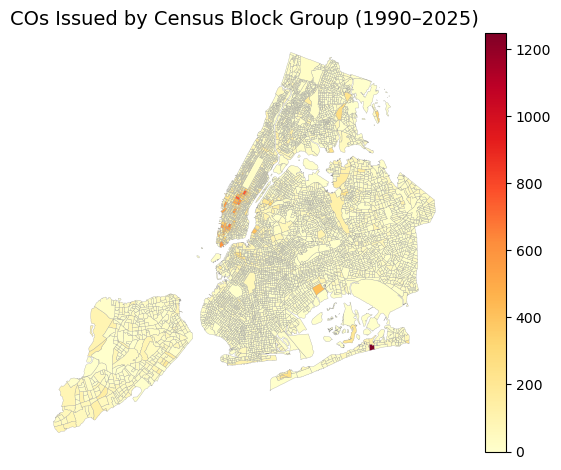

In [58]:
# Merge and Plot
bg_gdf['GEOID'] = bg_gdf['GEOID'].astype(str)
bg_counts['GEOID'] = bg_counts['GEOID'].astype(str)

merged = bg_gdf.merge(bg_counts, on='GEOID', how='left')
merged['CO_Count'] = merged['CO_Count'].fillna(0)

plt.figure(figsize=(12, 10))
merged.plot(column='CO_Count', cmap='YlOrRd', legend=True, edgecolor='0.6', linewidth=0.2)
plt.title('COs Issued by Census Block Group (1990–2025)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Load shapefile
bg_gdf = gpd.read_file("E:/Summer2025/UDA2025/Datasets/NYC_Block_Groups_2016_2020/NYC_Block_Groups_2016_2020.shp")

# Convert DOB data into GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
df_gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')  # Assuming WGS84

# Ensure CRS match
bg_gdf = bg_gdf.to_crs(df_gdf.crs)

# Spatial join
df_with_blocks = gpd.sjoin(df_gdf, bg_gdf[['GEOID', 'geometry']], how='inner', predicate='intersects')

# Group COs by GEOID
co_counts = df_with_blocks.groupby('GEOID').size().reset_index(name='CO_Count')

# Merge with population data
bg_gdf = bg_gdf.merge(co_counts, on='GEOID', how='left')
bg_gdf['CO_Count'] = bg_gdf['CO_Count'].fillna(0)

# Normalize by population (Pop1620)
bg_gdf['COs_per_1000'] = (bg_gdf['CO_Count'] / bg_gdf['Pop1620']) * 1000

In [67]:
# Remove problematic rows
bg_gdf = bg_gdf[(bg_gdf['Pop1620'] > 0) & (bg_gdf['CO_Count'].notna())]

# Recalculate and replace infinities or NaNs
bg_gdf['COs_per_1000'] = bg_gdf['CO_Count'] / bg_gdf['Pop1620'] * 1000
bg_gdf = bg_gdf.replace([np.inf, -np.inf], np.nan).dropna(subset=['COs_per_1000'])


c:\Users\vikto\miniconda3\envs\UDA\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Certificates of Occupancy (COs) per 1,000 residents across NYC block groups for 2016–2020, normalized and classified into quantiles.

This choropleth map visualizes the number of Certificates of Occupancy (COs) issued per 1,000 residents at the census block group level across New York City. Normalizing by population highlights which areas saw the most CO activity relative to population density.

High CO-per-capita clusters appear in fast-growing areas such as parts of Staten Island, Central Brooklyn, Long Island City, and the South Bronx suggesting targeted development activity. In contrast, many areas show low to moderate CO issuance relative to population, reflecting slower growth or housing stagnation.

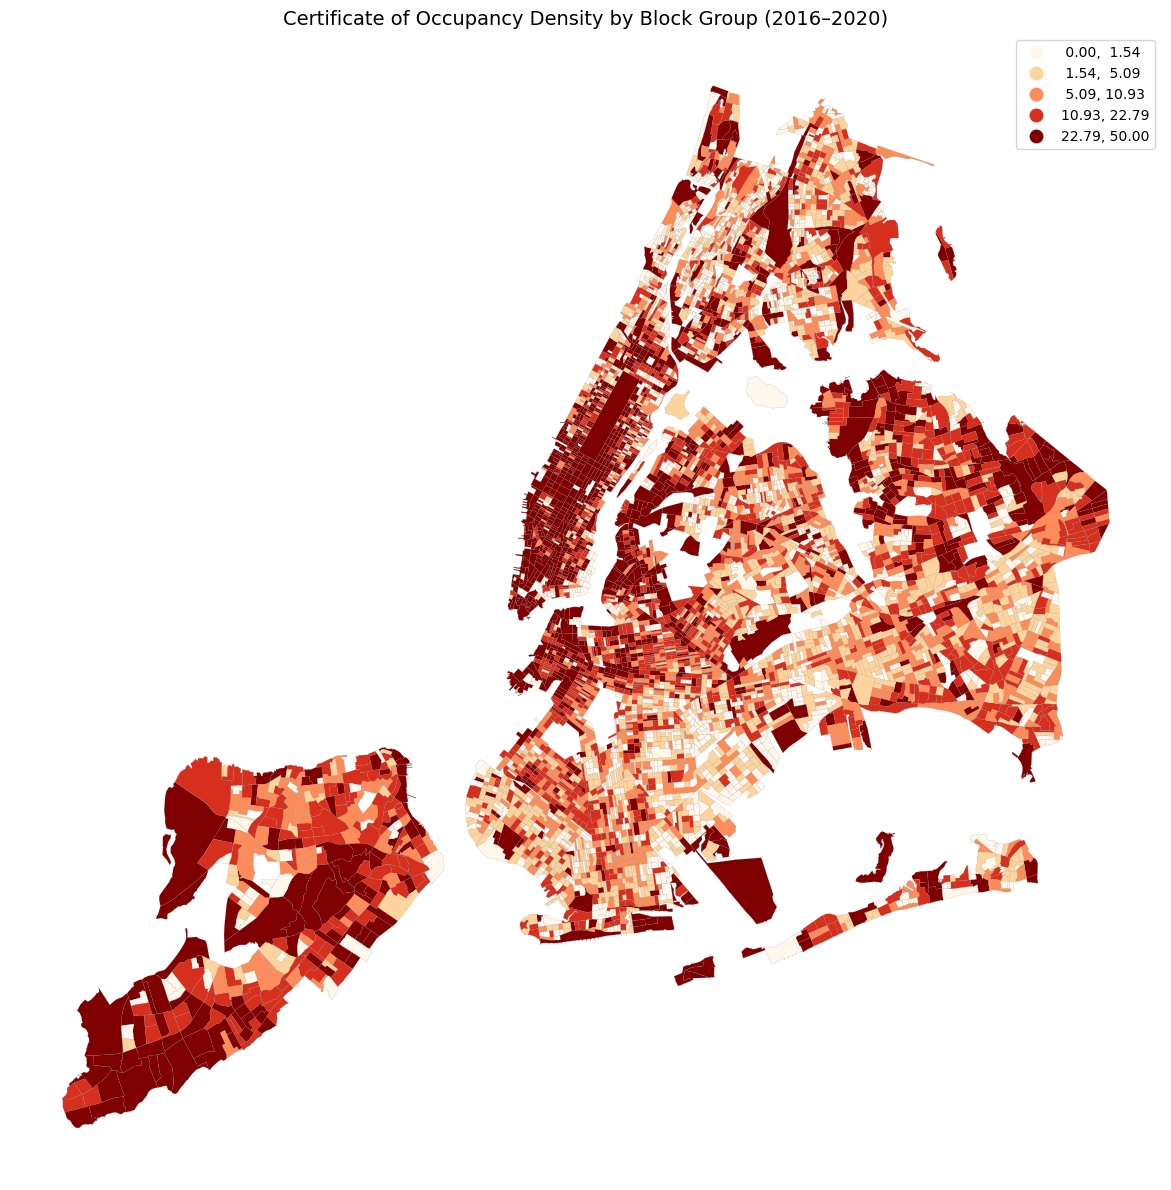

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

bg_gdf.plot(
    column='COs_per_1000_capped',
    cmap='OrRd',
    linewidth=0.1,
    edgecolor='gray',
    legend=True,
    scheme='quantiles',
    ax=ax
)

ax.set_title("Certificate of Occupancy Density by Block Group (2016–2020)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [66]:
bg_gdf['COs_per_1000'].describe()


c:\Users\vikto\miniconda3\envs\UDA\lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    6484.000000
mean             inf
std              NaN
min         0.000000
25%         2.426002
50%         7.814408
75%        19.221211
max              inf
Name: COs_per_1000, dtype: float64

## Multivariate Regression: Demographics and CO Intensity

Test whether wealthier and more educated block groups had more Certificates of Occupancy (COs) per 1,000 residents.

Effect of Demographic Variables on COs per 1,000 Residents.
This barplot displays standardized regression coefficients from a multivariate OLS model. It shows that:

Higher percentages of residents with Bachelor’s degrees (pctBA_degr) and graduate degrees (pctGraduat) are strongly and positively associated with increased Certificate of Occupancy (CO) issuance per 1,000 residents.

Median Household Income (MHI) is positively associated but has a much smaller effect size.

Percentage of residents with some college but no degree (pctCollege) shows a slight negative relationship, and its confidence interval overlaps zero, suggesting statistical insignificance.

In [71]:
# Drop rows with missing data
regression_data = bg_gdf[[
    'COs_per_1000_capped', 
    'MHI', 
    'pctCollege', 
    'pctBA_degr', 
    'pctGraduat'
]].dropna()

# Define X (independent vars) and y (dependent var)
X = regression_data[['MHI', 'pctCollege', 'pctBA_degr', 'pctGraduat']]
y = regression_data['COs_per_1000_capped']

# Add constant for intercept
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     COs_per_1000_capped   R-squared:                       0.156
Model:                             OLS   Adj. R-squared:                  0.155
Method:                  Least Squares   F-statistic:                     294.9
Date:                 Thu, 07 Aug 2025   Prob (F-statistic):          4.11e-233
Time:                         10:43:53   Log-Likelihood:                -25808.
No. Observations:                 6392   AIC:                         5.163e+04
Df Residuals:                     6387   BIC:                         5.166e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7996      0.706      6.80

In [ ]:
# Subset the necessary columns and drop NA rows
cols_to_scale = ['MHI', 'pctCollege', 'pctBA_degr', 'pctGraduat']
model_df = bg_gdf[cols_to_scale + ['COs_per_1000_capped']].dropna()

# Standardize predictors
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(model_df[cols_to_scale]), columns=cols_to_scale)

# Align index to match model_df
X_scaled.index = model_df.index  # 🔥 this is the fix!

# Add constant and set y
X_scaled = sm.add_constant(X_scaled)
y = model_df['COs_per_1000_capped']

# Run regression
model_std = sm.OLS(y, X_scaled).fit()
summary_std = model_std.summary()

# Convert for plotting
coef_df_std = model_std.summary2().tables[1].reset_index().rename(columns={'index': 'Variable'})


In [84]:
print(plot_df.columns.tolist())


['Variable', 'Coef.', 'Std.Err.', 't', 'P>|t|', '[0.025', '0.975]']


In [86]:
print(plot_df['Variable'].tolist())


['pctCollege', 'MHI', 'pctGraduat', 'pctBA_degr']


In [87]:
print(plot_df[['Variable', 'Coef.', 'err']])


     Variable     Coef.       err
2  pctCollege -0.034385  0.034471
1         MHI  0.000018  0.000009
4  pctGraduat  0.183148  0.030490
3  pctBA_degr  0.229953  0.030920


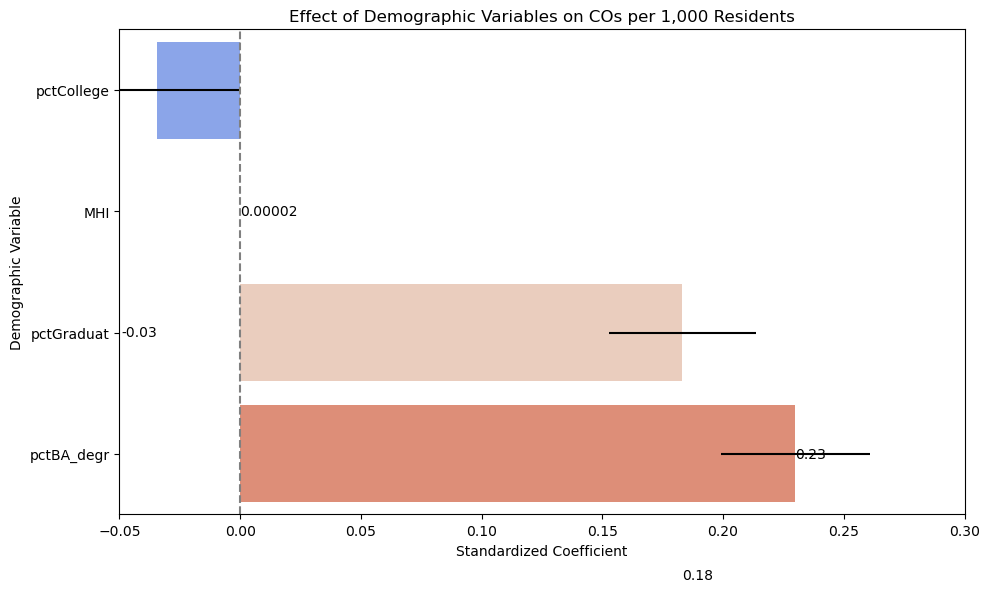

In [ ]:
# Sort variables
plot_df = plot_df.sort_values('Coef.')

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=plot_df,
    x='Coef.',
    y='Variable',
    xerr=plot_df['err'],
    palette='coolwarm'
)

# Add a vertical line at x=0
plt.axvline(0, color='gray', linestyle='--')

# Annotate each bar with the coefficient value
for i, row in plot_df.iterrows():
    plt.text(
        x=row['Coef.'],
        y=i,
        s=f"{row['Coef.']:.5f}" if abs(row['Coef.']) < 0.01 else f"{row['Coef.']:.2f}",
        va='center',
        ha='left' if row['Coef.'] >= 0 else 'right',
        color='black'
    )

# Adjust x-axis range to make small coefficients visible
plt.xlim(-0.05, 0.30)

# Labels and title
plt.xlabel("Standardized Coefficient")
plt.ylabel("Demographic Variable")
plt.title("Effect of Demographic Variables on COs per 1,000 Residents")

plt.tight_layout()
plt.show()


## Section 8: Conclusion and References

This analysis of NYC Department of Buildings Certificate of Occupancy (CO) data from 1990 to 2025 provides insight into the city’s housing development patterns over time and space, especially in light of the COVID-19 pandemic and changing urban dynamics. The following key findings emerged from the temporal, spatial, and statistical exploration:

- **Significant Variation by Job Type**: An ANOVA test revealed statistically significant differences in the average issuance year across major job types. New Buildings (NB) were concentrated in more recent years compared to Alteration 1 (A1) jobs, indicating differing construction timelines and priorities.

- **Post-Pandemic Decline**: A sharp decline in CO issuance was observed after 2019, coinciding with the onset of the COVID-19 pandemic. Independent t-tests and time series regression analysis confirmed this drop as statistically significant, pointing to pandemic-related disruptions such as labor shortages, supply chain issues, and permit delays.

- **Downward Citywide Trend**: Linear regression across all boroughs showed a generally negative slope in annual CO issuance, with a moderate R² value (≈ 0.42). This suggests a structural slowdown in construction beyond the immediate impact of the pandemic.

- **Borough-Level Differences**: Borough-specific regressions revealed distinct patterns. Manhattan showed the strongest declining trend (R² = 0.51), likely due to the sharp retreat from a previous construction boom. Brooklyn and Queens exhibited more variability, while the Bronx and Staten Island showed steadier, though still declining, post-pandemic trends.

- **Spatial Disparities in Development**: Choropleth mapping of COs per 1,000 residents revealed that new housing production is unevenly distributed. High per capita development rates were concentrated in southern Staten Island, eastern Queens, and parts of Brooklyn, while much of the Bronx and northern Manhattan exhibited significantly lower levels of new construction.

- **Demographic Correlates of Development**: Multivariate regression analysis showed that block groups with higher median household income and higher rates of bachelor's and graduate-level education were significantly more likely to have higher CO issuance per capita. These findings suggest that housing development is disproportionately concentrated in more affluent, educated neighborhoods, potentially reinforcing spatial inequality.

---

### References

- NYC Department of Buildings. *Certificate of Occupancy* dataset (accessed July 2025). [NYC Open Data Portal](https://data.cityofnewyork.us)
- U.S. Census Bureau. *2016–2020 American Community Survey (ACS) 5-Year Estimates* – Block Group Level.
- NYC Department of City Planning. *Zoning Handbook*, 2021 Edition.
- Gaber, J. (2022). *Qualitative Analysis for Planning and Policy*. 2nd Edition.
- Heris, M. P. (2025). *Statistics and Urban Data Analysis*, Lecture Slides and Assignments. Hunter College, CUNY.
